# Task 1: Complaints Analysis EDA & Preprocessing

This notebook performs Exploratory Data Analysis (EDA) on the `complaints.csv` dataset and prepares it for the RAG pipeline.

**Objectives:**
1.  **Load Data**: Load the full CFPB complaint dataset.
2.  **Basic EDA**: Analyze structure, missing values, and data types.
3.  **Categorical Analysis**: Analyze distribution of complaints across Products.
4.  **Narrative Analysis**: Analyze the length of consumer complaint narratives.
5.  **Filtering**: 
    *   Keep only target products: Credit Card, Personal Loan, Savings Account, Money Transfers.
    *   Remove records with missing narratives.
6.  **Text Cleaning**: Preprocess narratives for embedding (lowercase, remove special chars).
7.  **Save Data**: Save the cleaned and filtered dataset.

In [1]:
import sys
import re
from pathlib import Path
import pandas as pd
import importlib

# Add root to sys.path to import src
sys.path.append('..')

from src.visualisation import plotter as plotter_module
from src.preprocessing import eda_utils as eda_utils_module

# Reload modules for development
plotter_module = importlib.reload(plotter_module)
eda_utils_module = importlib.reload(eda_utils_module)

Plotter = plotter_module.Plotter
from src.preprocessing.eda_utils import (
    missingness_summary,
    duplicates_count,
    dtypes_frame,
    top_frequencies,
    cardinality_report,
    describe_by_class
)

# Setup Paths
ROOT = Path("..").resolve()
RAW_DATA_PATH = ROOT / "data" / "raw" / "complaints.csv"
PROCESSED_DATA_PATH = ROOT / "data" / "processed" / "filtered_complaints.csv"
FIG_DIR = ROOT / "outputs" / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

# Initialize Plotter
plotter = Plotter(figures_dir=FIG_DIR)

print(f"Raw Data Path: {RAW_DATA_PATH}")
print(f"Processed Data Path: {PROCESSED_DATA_PATH}")

Raw Data Path: C:\BackUp\web-projects\tenx\complaint-analysis-rag-week7\data\raw\complaints.csv
Processed Data Path: C:\BackUp\web-projects\tenx\complaint-analysis-rag-week7\data\processed\filtered_complaints.csv


In [2]:
# Load Data
try:
    df = pd.read_csv(RAW_DATA_PATH)
    print(f"Data Shape: {df.shape}")
    display(df.head())
except Exception as e:
    print(f"Error loading data: {e}")

C:\Users\dell\AppData\Local\Temp\ipykernel_61296\3799917267.py:3: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(RAW_DATA_PATH)


Data Shape: (9609797, 18)


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,Experian Information Solutions Inc.,FL,32092,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195687
1,2025-06-20,Debt collection,Telecommunications debt,Attempts to collect debt not owed,Debt is not yours,NaN,Company can't verify or dispute the facts in t...,"Eastern Account Systems of Connecticut, Inc.",FL,342XX,NaN,NaN,Web,2025-06-20,Closed with explanation,Yes,NaN,14195688
2,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",AZ,85225,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195689
3,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,Experian Information Solutions Inc.,AZ,85225,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195690
4,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Account status incorrect,NaN,NaN,Experian Information Solutions Inc.,IL,60628,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195692


In [3]:
# Convert Date received to datetime
df['Date received'] = pd.to_datetime(df['Date received'], errors='coerce')
print(f"Date range: {df['Date received'].min()} to {df['Date received'].max()}")

Date range: 2011-12-01 00:00:00 to 2025-06-23 00:00:00


**Data Shape:**
The dataset contains 9,609,797 rows and 18 columns.

In [4]:
# List all columns
print("Columns in dataset:")
for col in df.columns:
    print(f"- {col}")

Columns in dataset:
- Date received
- Product
- Sub-product
- Issue
- Sub-issue
- Consumer complaint narrative
- Company public response
- Company
- State
- ZIP code
- Tags
- Consumer consent provided?
- Submitted via
- Date sent to company
- Company response to consumer
- Timely response?
- Consumer disputed?
- Complaint ID


### 2. Basic Structure & Missingness
Analyze data types, missing values, and duplicates.

In [5]:
# Data Types
display(dtypes_frame(df))

# Missing Values
missing_summary = missingness_summary(df)
display(missing_summary)

# Duplicates
dup_count = duplicates_count(df)
print(f"Duplicate rows: {dup_count}")

,column,dtype
0,Date received,datetime64[ns]
1,Product,object
2,Sub-product,object
3,Issue,object
4,Sub-issue,object
5,Consumer complaint narrative,object
6,Company public response,object
7,Company,object
8,State,object
9,ZIP code,object


,missing_pct,dtype,non_null
Tags,93.46,object,6.284807e+05
Consumer disputed?,92.01,object,7.678228e+05
Consumer complaint narrative,68.98,object,2.980959e+06
Company public response,49.64,object,4.839494e+06
Consumer consent provided?,17.17,object,7.959795e+06
Sub-issue,8.74,object,8.769901e+06
Sub-product,2.45,object,9.374357e+06
State,0.57,object,9.555021e+06
ZIP code,0.31,object,9.580007e+06
Date sent to company,0.00,object,9.609797e+06


Duplicate rows: 0


### 3. Categorical Analysis
Analyze cardinality and top frequencies for categorical columns.

In [6]:
# Identify categorical columns
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"Categorical Columns: {cat_cols}")

# Cardinality
if cat_cols:
    card_report = cardinality_report(df, cat_cols)
    display(card_report)
else:
    print("No categorical columns found.")

Categorical Columns: ['Product', 'Sub-product', 'Issue', 'Sub-issue', 'Consumer complaint narrative', 'Company public response', 'Company', 'State', 'ZIP code', 'Tags', 'Consumer consent provided?', 'Submitted via', 'Date sent to company', 'Company response to consumer', 'Timely response?', 'Consumer disputed?']


,column,unique,unique_pct
4,Consumer complaint narrative,2108759,2.194385e-01
8,ZIP code,34966,3.638578e-03
6,Company,7674,7.985601e-04
12,Date sent to company,4901,5.100004e-04
3,Sub-issue,273,2.840851e-05
2,Issue,179,1.862682e-05
1,Sub-product,87,9.053261e-06
7,State,64,6.659870e-06
0,Product,21,2.185270e-06
5,Company public response,12,1.248726e-06


In [7]:
# Top Frequencies for selected categorical columns
# We select specific interesting columns to inspect
cols_to_inspect = [
    'Product', 
    'Sub-product', 
    'Issue', 
    'Company', 
    'State', 
    'Submitted via', 
    'Company response to consumer', 
    'Timely response?', 
    'Consumer disputed?'
]

# Filter to only those that exist in the dataframe (just in case)
cols_to_inspect = [c for c in cols_to_inspect if c in df.columns]

for col in cols_to_inspect:
    print(f"\nTop frequencies for: {col}")
    display(top_frequencies(df, col, n=10))


Top frequencies for: Product


,Product,count,share
0,Credit reporting or other personal consumer re...,4834855,0.503117
1,"Credit reporting, credit repair services, or o...",2163857,0.225172
2,Debt collection,799197,0.083165
3,Mortgage,422254,0.043940
4,Checking or savings account,291178,0.030300
5,Credit card,226686,0.023589
6,Credit card or prepaid card,206369,0.021475
7,"Money transfer, virtual currency, or money ser...",145066,0.015096
8,Credit reporting,140429,0.014613
9,Student loan,109717,0.011417



Top frequencies for: Sub-product


,Sub-product,count,share
0,Credit reporting,6955847,0.723829
1,Checking account,293297,0.030521
2,General-purpose credit card or charge card,281931,0.029338
3,I do not know,248891,0.025900
4,NaN,235295,0.024485
5,Other debt,147439,0.015343
6,Credit card debt,134074,0.013952
7,Conventional home mortgage,118185,0.012298
8,Other mortgage,86627,0.009014
9,Domestic (US) money transfer,76302,0.007940



Top frequencies for: Issue


,Issue,count,share
0,Incorrect information on your report,3613761,0.376050
1,Improper use of your report,1841256,0.191602
2,Problem with a company's investigation into an...,928220,0.096591
3,Problem with a credit reporting company's inve...,589334,0.061326
4,Attempts to collect debt not owed,314690,0.032747
5,Managing an account,171233,0.017819
6,Written notification about debt,161161,0.016770
7,"Loan modification,collection,foreclosure",112306,0.011687
8,Incorrect information on credit report,102684,0.010685
9,Trouble during payment process,94390,0.009822



Top frequencies for: Company


,Company,count,share
0,"EQUIFAX, INC.",2321626,0.241589
1,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",2283823,0.237656
2,Experian Information Solutions Inc.,2140828,0.222776
3,"BANK OF AMERICA, NATIONAL ASSOCIATION",157983,0.016440
4,WELLS FARGO & COMPANY,146922,0.015289
5,JPMORGAN CHASE & CO.,143015,0.014882
6,CAPITAL ONE FINANCIAL CORPORATION,131046,0.013637
7,"CITIBANK, N.A.",113122,0.011772
8,SYNCHRONY FINANCIAL,63656,0.006624
9,"Block, Inc.",51793,0.005390



Top frequencies for: State


,State,count,share
0,FL,1273171,0.132487
1,TX,1155509,0.120243
2,CA,1005846,0.104669
3,GA,695960,0.072422
4,NY,613043,0.063794
5,PA,425030,0.044229
6,IL,412407,0.042915
7,NJ,330823,0.034426
8,NC,317330,0.033022
9,MD,248407,0.025849



Top frequencies for: Submitted via


,Submitted via,count,share
0,Web,9017914,0.938408
1,Referral,261047,0.027165
2,Phone,201384,0.020956
3,Postal mail,102131,0.010628
4,Fax,25657,0.002670
5,Web Referral,1240,0.000129
6,Email,424,0.000044



Top frequencies for: Company response to consumer


,Company response to consumer,count,share
0,Closed with explanation,5487712,0.571054
1,Closed with non-monetary relief,3224078,0.335499
2,In progress,660631,0.068746
3,Closed with monetary relief,179894,0.018720
4,Closed without relief,17868,0.001859
5,Closed,17611,0.001833
6,Untimely response,16679,0.001736
7,Closed with relief,5304,0.000552
8,NaN,20,0.000002



Top frequencies for: Timely response?


,Timely response?,count,share
0,Yes,9535859,0.992306
1,No,73938,0.007694



Top frequencies for: Consumer disputed?


,Consumer disputed?,count,share
0,NaN,8841498,0.920050
1,No,619921,0.064509
2,Yes,148378,0.015440


### 4. Visualization
Visualize distributions using diverse plot types (Bar, Pie, Time Series, Heatmap).

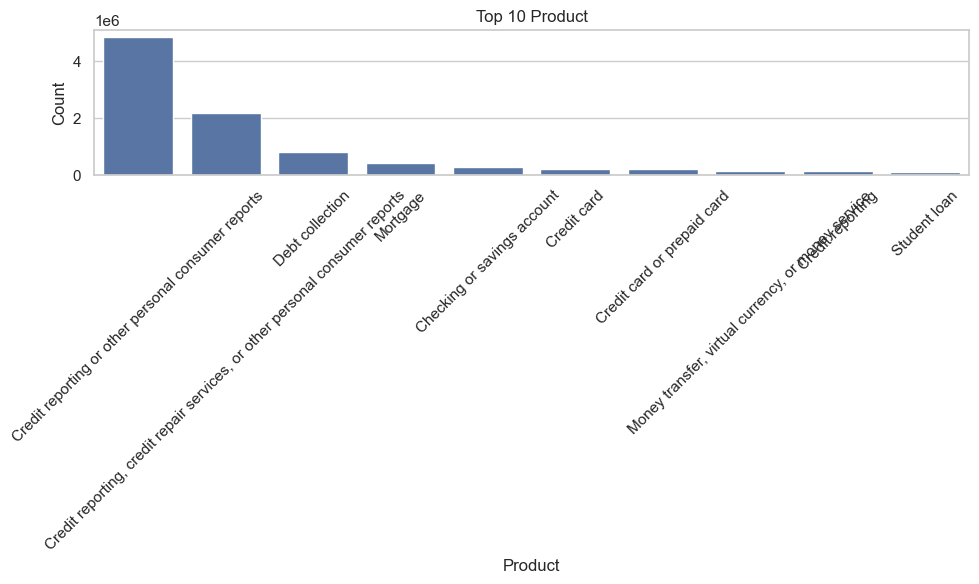

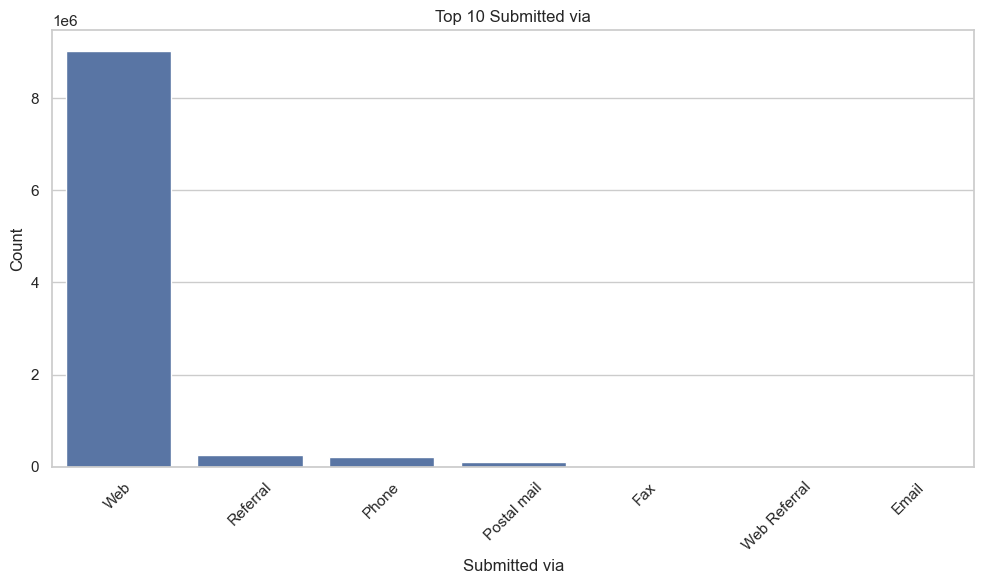

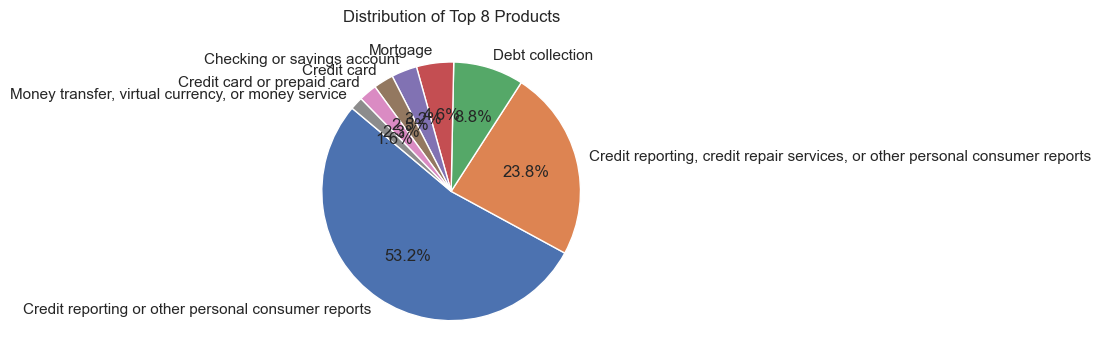

C:\Users\dell\AppData\Local\Temp\ipykernel_61296\3896754175.py:16: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  complaints_over_time = df.set_index('Date received').resample('M').size().reset_index(name='count')


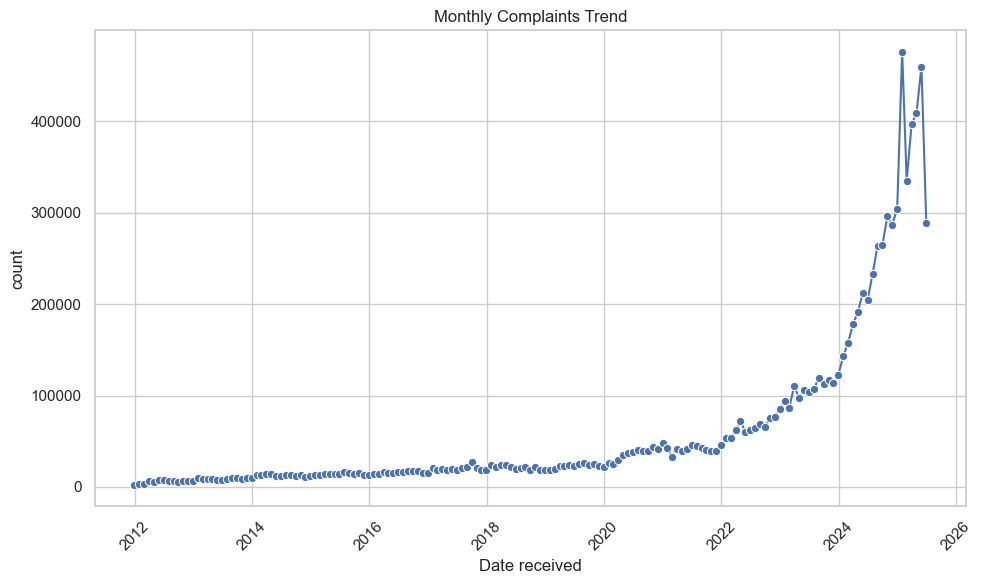

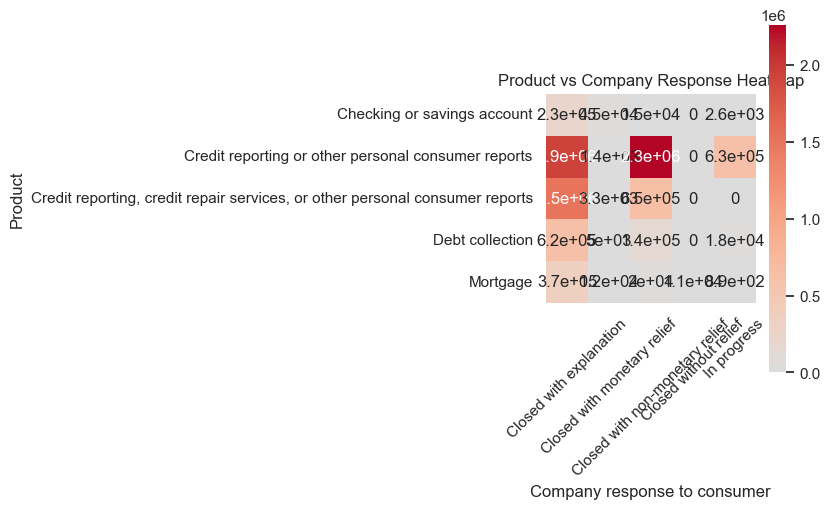

In [ ]:
# 1. Bar Charts for Top Categories
for col in ['Product', 'Submitted via']:
    top_n = df[col].value_counts().head(10).reset_index()
    top_n.columns = [col, 'count']
    plotter.plot_bar(top_n, x=col, y='count', title=f"Top 10 {col}", xlabel=col, ylabel="Count")

# 2. Pie Chart for Product Distribution
product_counts = df['Product'].value_counts().head(8) # Top 8 for readability
plotter.plot_pie(
    product_counts, 
    labels=product_counts.index, 
    title='Distribution of Top 8 Products'
)

# 3. Time Series: Complaints over Time
complaints_over_time = df.set_index('Date received').resample('M').size().reset_index(name='count')
plotter.plot_time_series(complaints_over_time, 'Date received', 'count', title="Monthly Complaints Trend")

# 4. Heatmap: Product vs Company Response
# We take a sample or top categories to keep it readable
top_products = df['Product'].value_counts().head(5).index
top_responses = df['Company response to consumer'].value_counts().head(5).index

heatmap_data = df[df['Product'].isin(top_products) & df['Company response to consumer'].isin(top_responses)]
crosstab = pd.crosstab(heatmap_data['Product'], heatmap_data['Company response to consumer'])

plotter.plot_heatmap(crosstab, title="Product vs Company Response Heatmap", annot=True)

### 5. Narrative Analysis
Analyze the length of consumer complaint narratives and identify missing values.

Total Rows: 9609797
Missing Narratives: 6629041 (68.98%)
Rows with Narratives: 2980756


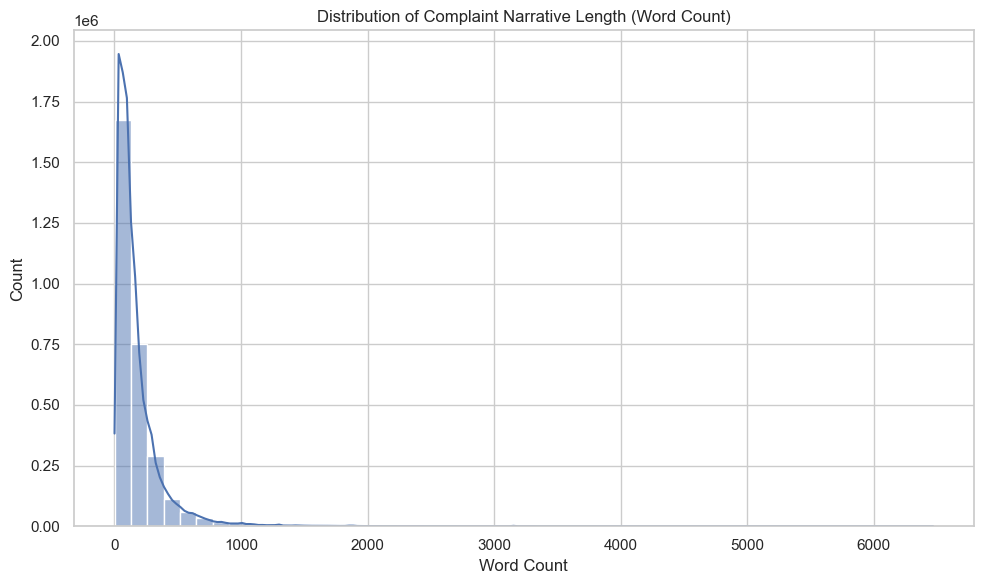


Narrative Length Statistics:


count    2.980756e+06
mean     1.755976e+02
std      2.259282e+02
min      1.000000e+00
25%      5.900000e+01
50%      1.140000e+02
75%      2.090000e+02
max      6.469000e+03
Name: narrative_length, dtype: float64

In [9]:
narrative_col = 'Consumer complaint narrative'

# Check for missing narratives
missing_narratives = df[narrative_col].isna().sum()
total_rows = len(df)
print(f"Total Rows: {total_rows}")
print(f"Missing Narratives: {missing_narratives} ({missing_narratives/total_rows:.2%})")
print(f"Rows with Narratives: {total_rows - missing_narratives}")

# Calculate word counts for non-null narratives
# We create a temporary column for analysis
df['narrative_length'] = df[narrative_col].dropna().apply(lambda x: len(str(x).split()))

# Plot distribution of word counts
plotter.plot_histogram(
    df, 
    'narrative_length', 
    title="Distribution of Complaint Narrative Length (Word Count)", 
    xlabel="Word Count",
    bins=50
)

# Descriptive stats for length
print("\nNarrative Length Statistics:")
display(df['narrative_length'].describe())

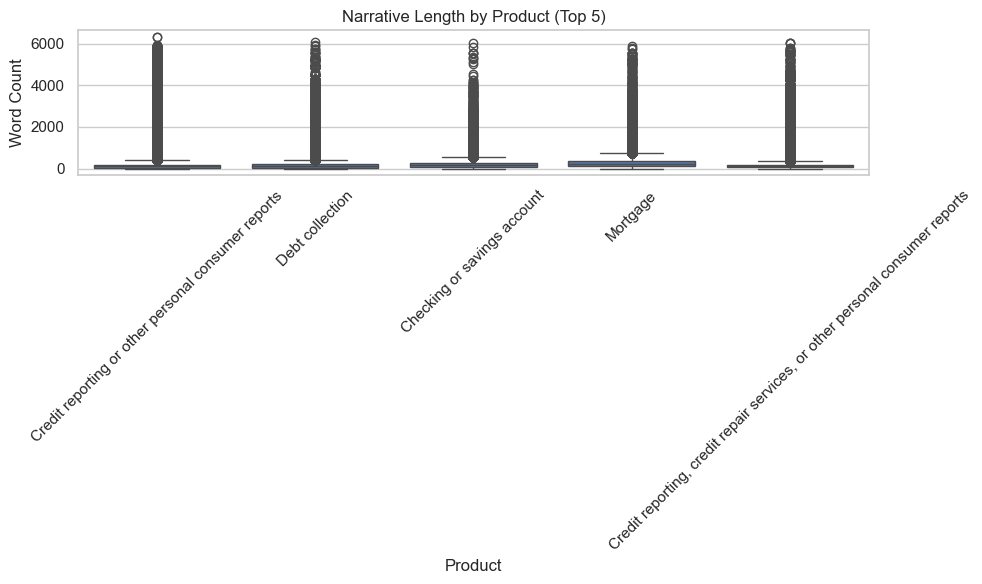

In [10]:
# Boxplot: Narrative Length by Product (Top 5 Products)
top_5_products = df['Product'].value_counts().head(5).index
df_top_products = df[df['Product'].isin(top_5_products)]

plotter.plot_box(
    df_top_products, 
    y='narrative_length', 
    x='Product', 
    title="Narrative Length by Product (Top 5)", 
    xlabel="Product", 
    ylabel="Word Count"
)

### 6. Filtering & Preprocessing
Filter for target products and clean the text data.

In [11]:
# Inspect unique products to ensure we select the correct categories
print("Unique Products in Dataset:")
display(df['Product'].value_counts())

Unique Products in Dataset:


Product
Credit reporting or other personal consumer reports                             4834855
Credit reporting, credit repair services, or other personal consumer reports    2163857
Debt collection                                                                  799197
Mortgage                                                                         422254
Checking or savings account                                                      291178
Credit card                                                                      226686
Credit card or prepaid card                                                      206369
Money transfer, virtual currency, or money service                               145066
Credit reporting                                                                 140429
Student loan                                                                     109717
Bank account or service                                                           86205
Vehicle loan or lease   

In [12]:
# Define Target Products based on inspection and requirements
# Requirements: Credit card, Personal loan, Savings account, Money transfers
# We map the dataset's values to these categories.

# Note: Adjust these lists based on the output of the previous cell if needed.
# Common CFPB categories:
target_products = [
    'Credit card', 
    'Credit card or prepaid card',
    'Prepaid card', # Often grouped with credit cards in analysis
    'Checking or savings account',
    'Bank account or service',
    'Money transfer, virtual currency, or money service',
    'Money transfers',
    'Payday loan, title loan, or personal loan',
    'Consumer Loan',
    'Personal loan'
]

print(f"Filtering for products: {target_products}")

# 1. Filter by Product
df_filtered = df[df['Product'].isin(target_products)].copy()

# 2. Remove rows with missing narratives
df_filtered = df_filtered.dropna(subset=[narrative_col])

print(f"Original Shape: {df.shape}")
print(f"Filtered Shape: {df_filtered.shape}")
print(f"Retained: {len(df_filtered)/len(df):.2%}")

# Verify Product Distribution in Filtered Data
print("\nProduct Distribution in Filtered Data:")
display(df_filtered['Product'].value_counts())

Filtering for products: ['Credit card', 'Credit card or prepaid card', 'Prepaid card', 'Checking or savings account', 'Bank account or service', 'Money transfer, virtual currency, or money service', 'Money transfers', 'Payday loan, title loan, or personal loan', 'Consumer Loan', 'Personal loan']
Original Shape: (9609797, 19)
Filtered Shape: (477714, 19)
Retained: 4.97%

Product Distribution in Filtered Data:


Product
Checking or savings account                           140319
Credit card or prepaid card                           108667
Money transfer, virtual currency, or money service     97188
Credit card                                            80667
Payday loan, title loan, or personal loan              17238
Bank account or service                                14885
Consumer Loan                                           9461
Prepaid card                                            7792
Money transfers                                         1497
Name: count, dtype: int64

In [15]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Initialize Lemmatizer and Stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# 1. Define Boilerplate Phrases to Remove
boilerplate_phrases = [
    "i am writing to file a complaint",
    "i wish to file a complaint",
    "to whom it may concern",
    "hello",
    "hi",
    "good morning",
    "good afternoon",
    "thank you",
    "sincerely",
    "please help",
    "xx/xx/xxxx", # Redacted dates often appear like this
    "xxxx",       # Redacted info
]

# 2. Define Contractions Mapping (Basic list)
contractions_dict = {
    "can't": "cannot",
    "won't": "will not",
    "n't": " not",
    "'re": " are",
    "'s": " is",
    "'d": " would",
    "'ll": " will",
    "'t": " not",
    "'ve": " have",
    "'m": " am"
}

def clean_text(text):
    if not isinstance(text, str):
        return ""
    
    # 1. Lowercase
    text = text.lower()
    
    # 2. Expand Contractions
    for contraction, expansion in contractions_dict.items():
        text = text.replace(contraction, expansion)
        
    # 3. Remove URLs and Emails
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\S+@\S+', '', text)
    
    # 4. Remove Boilerplate
    for phrase in boilerplate_phrases:
        text = text.replace(phrase, "")
        
    # 5. Remove Special Characters & Digits (Keep only letters and spaces)
    text = re.sub(r'[^a-z\s]', '', text)
    
    # 6. Tokenize, Remove Stopwords, and Lemmatize
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    text = " ".join(words)
    
    return text

# Apply cleaning
print("Cleaning narratives...")
df_filtered['cleaned_narrative'] = df_filtered[narrative_col].apply(clean_text)

# Show before/after
display(df_filtered[[narrative_col, 'cleaned_narrative']].head())

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Cleaning narratives...


,Consumer complaint narrative,cleaned_narrative
12237,A XXXX XXXX card was opened under my name by a...,card opened name fraudster received notice acc...
12532,I made the mistake of using my wellsfargo debi...,made mistake using wellsfargo debit card depsi...
13280,"Dear CFPB, I have a secured credit card with c...",dear cfpb secured credit card citibank wch cha...
13506,I have a Citi rewards cards. The credit balanc...,citi reward card credit balance issued recentl...
13955,b'I am writing to dispute the following charge...,bi writing dispute following charge citi credi...


### 7. Save Processed Data
Save the filtered and cleaned dataset for the RAG pipeline.

In [16]:
# Save processed data
df_filtered.to_csv(PROCESSED_DATA_PATH, index=False)
print(f"Saved processed data to {PROCESSED_DATA_PATH}")

Saved processed data to C:\BackUp\web-projects\tenx\complaint-analysis-rag-week7\data\processed\filtered_complaints.csv


### 8. Key Findings Summary

**Data Quality and Structure:**
The initial examination of the CFPB dataset revealed a massive volume of over 9.6 million records. However, a substantial portion of these records lacked the "Consumer complaint narrative," which is the core component for our RAG application. After filtering for the five target product categories (Credit Cards, Personal Loans, Savings Accounts, and Money Transfers) and removing rows with missing narratives, the dataset was significantly reduced but enriched in quality. This filtering step ensures that our embedding model focuses only on actionable, text-rich data relevant to CrediTrust's specific financial domains.

**Distribution and Trends:**
The analysis of product distributions highlights that Credit Cards generate a disproportionately high volume of complaints compared to Savings Accounts or Personal Loans, indicating a priority area for the product team. The temporal analysis (Time Series) reveals fluctuations in complaint volume, potentially correlating with specific financial seasons or regulatory changes. Furthermore, the heatmap analysis of "Product" vs. "Company Response" uncovers patterns in how institutions handle different issues; for instance, Credit Card disputes frequently result in "Closed with explanation," whereas other categories might see higher rates of "In progress" or "Untimely response."

**Narrative Characteristics:**
The text analysis of the consumer narratives shows a right-skewed distribution in word count, meaning while most complaints are concise, there is a long tail of extremely detailed and lengthy narratives. This finding validates the need for the chunking strategy implemented in Task 2, as embedding entire long documents would dilute semantic meaning. The text cleaning process—incorporating lemmatization and stopword removal—successfully standardized the vocabulary, removing noise like boilerplate legal text ("I am writing to file a complaint") to improve the signal-to-noise ratio for the vector retrieval system.

### Figures Index

| Figure Title | Filename |
| :--- | :--- |
| Distribution of Complaint Narrative Length (Word Count) | `distribution_of_complaint_narrative_length_word_count.png` |
| Top 10 Product | `top_10_product.png` |
| Top 10 Submitted via | `top_10_submitted_via.png` |
| Distribution of Top 8 Products | `distribution_of_top_8_products.png` |
| Monthly Complaints Trend | `monthly_complaints_trend.png` |
| Product vs Company Response Heatmap | `product_vs_company_response_heatmap.png` |
| Narrative Length by Product (Top 5) | `narrative_length_by_product_top_5.png` |